In [30]:
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestRegressor,ExtraTreesClassifier,RandomForestClassifier
from sklearn.preprocessing import StandardScaler,KBinsDiscretizer,LabelEncoder,MinMaxScaler
from sklearn.metrics import mean_squared_error,f1_score
from sklearn.kernel_approximation import Nystroem
from sklearn.neighbors import KNeighborsClassifier

from catboost import Pool, cv,CatBoostClassifier,CatBoostRegressor

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, concatenate,Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers
import tensorflow_addons as tfa

from tqdm import tqdm

import lightgbm as lgb

from imblearn.over_sampling import RandomOverSampler,SMOTE, ADASYN

In [ ]:
train_df = pd.read_csv('train_df_final_balanced.csv')
train_df = train_df.fillna(0)
test_df = pd.read_csv('test_df_final.csv')
test_df = test_df.fillna(0)
submission_df = pd.read_csv('sample_submission.csv')

In [87]:
y = train_df['label'].values

In [88]:
y.sum()/y.shape[0]

0.9100607060765015

In [90]:
y.sum()/y.shape[0]

0.8888952852455242

In [91]:
model_predictions_train = pd.DataFrame()
model_predictions_train['label'] = train_df['label']
model_predictions_test = pd.DataFrame()

In [92]:
for column in train_df.columns:
    print(column)

additional_fare
duration
meter_waiting
meter_waiting_fare
meter_waiting_till_pickup
fare
pickup_date
pickup_hour
pickup_minute
drop_date
drop_hour
drop_minute
pick_cluster
is_more_than_one_day
distance_km
fare_per_km
pickup_timeslot
day_of_week
is_weekday
cal_time_difference
label
predicted_fare
predicted_fare_diff
predicted_fare_diff_per_fare
predicted_fare_diff_per_predicted_fare
fare_per_distance
predicted_fare_per_distance
predicted_fare_diff_per_distance
predicted_duration
predicted_duration_diff
predicted_duraton_diff_per_duraton
predicted_duraton_diff_per_predicted_duration
predicted_duraton_diff_per_distance
fare_per_duration
predicted_fare_per_duration
predicted_fare_per_duration_diff
avg_speed
predicted_avg_speed
predicted_avg_speed_diff
predicted_meter_waiting
predicted_meter_waiting_diff
predicted_meter_waiting_diff_per_meter_waiting
predicted_meter_waiting_diff_per_distance
predicted_meter_waiting_diff_per_predicted_meter_waiting
meter_waiting_per_duration
predicted_meter_

# Boosted decision trees

## Anomaly based

In [93]:
features = [
    'fare_anomaly',
    'additional_fare_anomaly', 
    'duration_anomaly',
    'meter_waiting_anomaly', 
    'meter_waiting_fare_anomaly',
    'meter_waiting_till_pickup_anomaly', 
    'additional_fare_duration_anomaly',
    'additional_fare_meter_waiting_anomaly',
    'additional_fare_meter_waiting_fare_anomaly',
    'additional_fare_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_anomaly', 
    'duration_meter_waiting_fare_anomaly',
    'duration_meter_waiting_till_pickup_anomaly',
    'meter_waiting_meter_waiting_fare_anomaly',
    'meter_waiting_meter_waiting_till_pickup_anomaly',
    'meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'additional_fare_duration_meter_waiting_anomaly',
    'additional_fare_duration_meter_waiting_fare_anomaly',
    'additional_fare_duration_meter_waiting_till_pickup_anomaly',
    'additional_fare_meter_waiting_meter_waiting_fare_anomaly',
    'additional_fare_meter_waiting_meter_waiting_till_pickup_anomaly',
    'additional_fare_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_meter_waiting_fare_anomaly',
    'duration_meter_waiting_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'additional_fare_duration_meter_waiting_meter_waiting_fare_anomaly',
    'additional_fare_duration_meter_waiting_meter_waiting_till_pickup_anomaly',
    'additional_fare_duration_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'additional_fare_meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
]

cat_features = [
    'fare_anomaly',
    'additional_fare_anomaly', 
    'duration_anomaly',
    'meter_waiting_anomaly', 
    'meter_waiting_fare_anomaly',
    'meter_waiting_till_pickup_anomaly', 
    'additional_fare_duration_anomaly',
    'additional_fare_meter_waiting_anomaly',
    'additional_fare_meter_waiting_fare_anomaly',
    'additional_fare_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_anomaly', 
    'duration_meter_waiting_fare_anomaly',
    'duration_meter_waiting_till_pickup_anomaly',
    'meter_waiting_meter_waiting_fare_anomaly',
    'meter_waiting_meter_waiting_till_pickup_anomaly',
    'meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'additional_fare_duration_meter_waiting_anomaly',
    'additional_fare_duration_meter_waiting_fare_anomaly',
    'additional_fare_duration_meter_waiting_till_pickup_anomaly',
    'additional_fare_meter_waiting_meter_waiting_fare_anomaly',
    'additional_fare_meter_waiting_meter_waiting_till_pickup_anomaly',
    'additional_fare_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_meter_waiting_fare_anomaly',
    'duration_meter_waiting_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'additional_fare_duration_meter_waiting_meter_waiting_fare_anomaly',
    'additional_fare_duration_meter_waiting_meter_waiting_till_pickup_anomaly',
    'additional_fare_duration_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'additional_fare_meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
]

In [94]:
train = train_df[features]
test = test_df[features]
y = train_df['label']

In [95]:
def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat,average='micro'), True

### catboost

In [96]:
catboost_params = {
    'loss_function':'Logloss',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'F1',
}

In [97]:
submission_pool = Pool(data=test_df[features], cat_features=cat_features)

In [98]:
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
train_class = np.zeros(train_df.shape[0])
test_class = np.zeros(test_df.shape[0])
skf = StratifiedKFold(n_splits=3)
validation_scores = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostClassifier(**catboost_params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    train_preds[test_index] = model.predict_proba(test_pool)[:,1]
    train_class[test_index] = model.predict(test_pool)
    test_preds += model.predict_proba(submission_pool)[:,1]/3
    test_class = model.predict(submission_pool)
    validation_scores.append(f1_score(y_test,model.predict(test_pool),average='micro'))
test_class = np.where(test_class > 2, 1, 0)

Learning rate set to 0.058029
0:	learn: 0.9425393	test: 0.9424335	best: 0.9424335 (0)	total: 10.7ms	remaining: 10.7s
10:	learn: 0.9426151	test: 0.9419201	best: 0.9424335 (0)	total: 59.3ms	remaining: 5.33s
20:	learn: 0.9431766	test: 0.9418338	best: 0.9424335 (0)	total: 105ms	remaining: 4.91s
30:	learn: 0.9434793	test: 0.9422654	best: 0.9424335 (0)	total: 150ms	remaining: 4.69s
40:	learn: 0.9441559	test: 0.9432403	best: 0.9432403 (39)	total: 202ms	remaining: 4.72s
50:	learn: 0.9445032	test: 0.9434032	best: 0.9435002 (46)	total: 270ms	remaining: 5.02s
60:	learn: 0.9447921	test: 0.9433928	best: 0.9435002 (46)	total: 316ms	remaining: 4.86s
70:	learn: 0.9453507	test: 0.9444393	best: 0.9444393 (68)	total: 364ms	remaining: 4.76s
80:	learn: 0.9454948	test: 0.9445059	best: 0.9445059 (78)	total: 460ms	remaining: 5.21s
90:	learn: 0.9457028	test: 0.9445725	best: 0.9445930 (82)	total: 515ms	remaining: 5.14s
100:	learn: 0.9458337	test: 0.9444752	best: 0.9445930 (82)	total: 565ms	remaining: 5.03s
110:

In [99]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.8959183780998585, 0.001560324199585342, 0.8939550949913644)

In [64]:
name = 'catboost_anomaly'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

## LightGBM

In [65]:
lgb_params = {
    'objective':'binary',
    'learning_rate':0.05,
    'seed':0, 
    'metric':'f1',
    'max_depth':6
}

In [66]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_data = lgb.Dataset(X_train,y_train)
    valid_data = lgb.Dataset(X_test,y_test)
    evals_result = {}
    model = lgb.train(lgb_params, train_data,num_boost_round=1000,early_stopping_rounds=50, valid_sets=valid_data,feval=lgb_f1_score, evals_result=evals_result,verbose_eval=False)
    
    test_preds += model.predict(test) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,np.round(model.predict(X_test)),average='micro'))

In [67]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.7888698785915483, 0.0011391070706930292, 0.7873993893977241)

In [68]:
name = 'lgb_anomaly'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

## K-NN

In [17]:
knn_params = {
    'n_neighbors':15,
    'weights':'uniform'    
}

In [18]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:].values, train.iloc[test_index,:].values
    y_train, y_test = y[train_index], y[test_index]
    
    model = KNeighborsClassifier(**knn_params)
    model.fit(X_train, y_train)
    
    test_preds += model.predict(test.values) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,model.predict(X_test),average='micro'))

In [19]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9117108878375522, 0.001250383548715244, 0.9103448275862069)

In [20]:
name = 'knn_anomaly'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

## Random forests

In [21]:
rf_params = {
    'n_estimators':50,
    'max_depth':10,
    'random_state':0,    
}

In [22]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:].values, train.iloc[test_index,:].values
    y_train, y_test = y[train_index], y[test_index]
    
    model = RandomForestClassifier(**rf_params)
    model.fit(X_train, y_train)
    
    test_preds += model.predict(test.values) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,model.predict(X_test),average='micro'))

In [23]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9125361058273315, 7.606512654814278e-05, 0.9124823196605375)

In [24]:
name = 'rf_anomaly'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

## SVC

In [52]:
svc_params = {
    'C':2,
    'kernel':'linear',
    'random_state':0,    
    'probability': False,
    'gamma':'scale'
}

In [53]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:].values, train.iloc[test_index,:].values
    y_train, y_test = y[train_index], y[test_index]
    
    model = SVC(**svc_params)
    model.fit(X_train, y_train)
    
    test_preds += model.predict(test.values) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,model.predict(X_test),average='micro'))

In [54]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9112394746484881, 0.0008026435619151851, 0.9101838755304101)

In [55]:
name = 'svc_linear_anomaly'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

In [59]:
svc_params = {
    'C':2,
    'kernel':'rbf',
    'random_state':0,    
    'probability': False,
    'gamma':'scale'
}

In [60]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:].values, train.iloc[test_index,:].values
    y_train, y_test = y[train_index], y[test_index]
    
    model = SVC(**svc_params)
    model.fit(X_train, y_train)
    
    test_preds += model.predict(test.values) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,model.predict(X_test),average='micro'))

In [61]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9135969470383948, 0.0012302422268772803, 0.9124823196605375)

In [62]:
name = 'svc_rbf_anomaly'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

# Base features

In [64]:
features = [
    'additional_fare',
    'duration',
    'meter_waiting',
    'meter_waiting_fare',
    'meter_waiting_till_pickup',
    'fare',
    'pickup_date',
    'pickup_hour',
    'pickup_minute',
    'drop_date',
    'drop_hour',
    'drop_minute',
    'pick_cluster',
    'is_more_than_one_day',
    'distance_km',
    'fare_per_km',
    'pickup_timeslot',
    'day_of_week',
    'is_weekday',
    'cal_time_difference',
    'fare_per_distance',
    'fare_per_duration',
    'avg_speed',
    'meter_waiting_per_duration',
    'meter_waiting_fare_per_meter_waiting',
    'meter_waiting_fare_per_duration',
    'addtional_fare_per_fare',
    'addtional_fare_per_distance',
    'addtional_fare_per_duration',
    'fare-additional_fare',
    'fare-additional_fare-meter_waiting_fare',
    'fare-additional_fare_per_distance',
    'fare-additional_fare_per_duration',
    'fare-additional_fare-meter_waiting_fare_per_distance',
    'fare-additional_fare-meter_waiting_fare_per_duration',
    'meter_waiting_till_pickup_per_meter_waiting',
    'meter_waiting_after_pickup',
    'meter_waiting_after_pickup_per_duration',
    'meter_waiting_till_pickup_per_duration',
    'meter_waiting_till_pickup_per_distance',
    'meter_waiting_after_pickup_per_distance',
    'meter_waiting_till_pickup_per_fare',
    'meter_waiting_after_pickup_per_fare',
    'meter_waiting_till_pickup_per_meter_waiting_fare',
    'meter_waiting_after_pickup_per_meter_waiting_fare',
    'fare_per_distance_mean',
    'fare_per_distance_mean_diff',
    'avg_speed_mean',
    'avg_speed_mean_diff',
    'meter_waiting_per_duration_mean',
    'meter_waiting_per_duration_mean_diff',
    'meter_waiting_fare_per_meter_waiting_mean',
    'meter_waiting_fare_per_meter_waiting_mean_diff',
    'meter_waiting_fare_per_duration_mean',
    'meter_waiting_fare_per_duration_mean_diff',
    'addtional_fare_per_fare_mean',
    'addtional_fare_per_fare_mean_diff',
    'addtional_fare_per_distance_mean',
    'addtional_fare_per_distance_mean_diff',
    'addtional_fare_per_duration_mean',
    'addtional_fare_per_duration_mean_diff',
]

cat_features = [
    'pickup_date',
    'pickup_hour',
    'pickup_minute',
    'drop_date',
    'drop_hour',
    'drop_minute',
    'pick_cluster',
    'is_more_than_one_day',
    'pickup_timeslot',
    'day_of_week',
    'is_weekday',
]

In [65]:
train = train_df[features]
test = test_df[features]
y = train_df['label']

### Catboost

In [66]:
catboost_params = {
    'loss_function':'Logloss',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'F1',
    'border_count':512
}

In [67]:
submission_pool = Pool(data=test_df[features], cat_features=cat_features)

In [68]:
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
train_class = np.zeros(train_df.shape[0])
test_class = np.zeros(test_df.shape[0])
skf = StratifiedKFold(n_splits=3)
validation_scores = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostClassifier(**catboost_params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    train_preds[test_index] = model.predict_proba(test_pool)[:,1]
    train_class[test_index] = model.predict(test_pool)
    test_preds += model.predict_proba(submission_pool)[:,1]/3
    test_class = model.predict(submission_pool)
    validation_scores.append(f1_score(y_test,model.predict(test_pool),average='micro'))
test_class = np.where(test_class > 2, 1, 0)

Learning rate set to 0.057693
0:	learn: 0.9648677	test: 0.9632484	best: 0.9632484 (0)	total: 28.5ms	remaining: 28.5s
10:	learn: 0.9698978	test: 0.9703045	best: 0.9708389 (3)	total: 236ms	remaining: 21.2s
20:	learn: 0.9729190	test: 0.9763629	best: 0.9763629 (20)	total: 448ms	remaining: 20.9s
30:	learn: 0.9749917	test: 0.9770905	best: 0.9771080 (23)	total: 658ms	remaining: 20.6s
40:	learn: 0.9773194	test: 0.9772531	best: 0.9777437 (38)	total: 866ms	remaining: 20.2s
50:	learn: 0.9787295	test: 0.9744628	best: 0.9777437 (38)	total: 1.18s	remaining: 22s
60:	learn: 0.9794806	test: 0.9716881	best: 0.9777437 (38)	total: 1.48s	remaining: 22.8s
70:	learn: 0.9801838	test: 0.9708587	best: 0.9777437 (38)	total: 1.71s	remaining: 22.3s
80:	learn: 0.9806532	test: 0.9661676	best: 0.9777437 (38)	total: 1.94s	remaining: 22s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9777436685
bestIteration = 38

Shrink model to first 39 iterations.
Learning rate set to 0.057693
0:	learn: 0.964467

In [69]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9553246846094234, 0.00432615100961109, 0.9492484526967285)

In [70]:
name = 'catboost_base'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

### lgb

In [71]:
lgb_params = {
    'objective':'binary',
    'learning_rate':0.05,
    'seed':0, 
    'metric':'f1',
    'max_depth':6
}

In [72]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_data = lgb.Dataset(X_train,y_train)
    valid_data = lgb.Dataset(X_test,y_test)
    evals_result = {}
    model = lgb.train(lgb_params, train_data,num_boost_round=1000,early_stopping_rounds=50, valid_sets=valid_data,feval=lgb_f1_score, evals_result=evals_result)
    
    test_preds += model.predict(test) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,np.round(model.predict(X_test)),average='micro'))

[1]	valid_0's f1: 0.910007
Training until validation scores don't improve for 50 rounds
[2]	valid_0's f1: 0.910007
[3]	valid_0's f1: 0.910007
[4]	valid_0's f1: 0.910007
[5]	valid_0's f1: 0.910007
[6]	valid_0's f1: 0.910007
[7]	valid_0's f1: 0.910007
[8]	valid_0's f1: 0.910007
[9]	valid_0's f1: 0.910184
[10]	valid_0's f1: 0.910537
[11]	valid_0's f1: 0.911245
[12]	valid_0's f1: 0.930516
[13]	valid_0's f1: 0.941124
[14]	valid_0's f1: 0.945721
[15]	valid_0's f1: 0.949611
[16]	valid_0's f1: 0.950849
[17]	valid_0's f1: 0.951909
[18]	valid_0's f1: 0.952793
[19]	valid_0's f1: 0.95297
[20]	valid_0's f1: 0.954031
[21]	valid_0's f1: 0.953854
[22]	valid_0's f1: 0.953678
[23]	valid_0's f1: 0.953678
[24]	valid_0's f1: 0.953678
[25]	valid_0's f1: 0.954208
[26]	valid_0's f1: 0.954562
[27]	valid_0's f1: 0.955269
[28]	valid_0's f1: 0.955622
[29]	valid_0's f1: 0.955622
[30]	valid_0's f1: 0.955269
[31]	valid_0's f1: 0.955092
[32]	valid_0's f1: 0.955092
[33]	valid_0's f1: 0.955446
[34]	valid_0's f1: 0.9559

In [73]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9552657709878605, 0.004046219701044328, 0.9496021220159151)

In [74]:
name = 'lgb_base'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

# Linear prediction difference

In [75]:
features = [
    'predicted_fare_diff',
    'predicted_fare_diff_per_fare',
    'predicted_fare_diff_per_predicted_fare',
    'predicted_fare_diff_per_distance',
    'predicted_duration_diff',
    'predicted_duraton_diff_per_duraton',
    'predicted_duraton_diff_per_predicted_duration',
    'predicted_duraton_diff_per_distance',
    'predicted_fare_per_duration_diff',
    'predicted_avg_speed_diff',
    'predicted_meter_waiting_diff',
    'predicted_meter_waiting_diff_per_meter_waiting',
    'predicted_meter_waiting_diff_per_distance',
    'predicted_meter_waiting_diff_per_predicted_meter_waiting',
    'predicted_meter_waiting_per_duration_diff',
    'predicted_meter_waiting_fare_diff',
    'predicted_meter_waiting_fare_diff_per_distance',
    'predicted_meter_waiting_fare_diff_per_predicted_meter_waiting_fare',
    'predicted_meter_waiting_fare_per_meter_waiting_diff',
    'predicted_meter_waiting_fare_per_duration_diff',
    'predicted_additional_fare_diff',
    'predicted_additional_fare_diff_per_additional_fare',
    'predicted_addtional_fare_diff_per_distance',
    'predicted_meter_waiting_till_pickup_diff',
    'predicted_meter_waiting_till_pickup_diff_per_meter_waiting_till_pickup',
    'predicted_meter_waiting_till_pickup_per_meter_waiting_diff',
    'predicted_fare_diff_per_distance_normalized',
    'predicted_fare_diff_normalized',
    'predicted_fare_diff_per_fare_normalized',
    'predicted_fare_diff_per_predicted_fare_normalized',
    'predicted_duraton_diff_per_duraton_normalized',
    'predicted_duraton_diff_per_predicted_duration_normalized',
    'predicted_fare_per_duration_diff_normalized',
    'predicted_avg_speed_diff_normalized',
    'predicted_meter_waiting_diff_normalized',
    'predicted_meter_waiting_diff_per_meter_waiting_normalized',
    'predicted_meter_waiting_diff_per_predicted_meter_waiting_normalized',
    'predicted_meter_waiting_per_duration_diff_normalized',
    'predicted_meter_waiting_fare_diff_normalized',
    'predicted_meter_waiting_fare_diff_per_meter_waiting_fare_normalized',
    'predicted_meter_waiting_fare_diff_per_predicted_meter_waiting_fare_normalized',
    'predicted_meter_waiting_fare_per_meter_waiting_diff_normalized',
    'predicted_meter_waiting_fare_per_duration_diff_normalized',
    'predicted_additional_fare_diff_normalized',
    'predicted_additional_fare_diff_per_additional_fare_normalized',
]

cat_features = []

In [76]:
train = train_df[features]
test = test_df[features]
y = train_df['label']

### Catboost

In [77]:
catboost_params = {
    'loss_function':'Logloss',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'F1',
    'border_count':512
}

In [78]:
submission_pool = Pool(data=test_df[features], cat_features=cat_features)

In [79]:
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
train_class = np.zeros(train_df.shape[0])
test_class = np.zeros(test_df.shape[0])
skf = StratifiedKFold(n_splits=3)
validation_scores = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostClassifier(**catboost_params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    train_preds[test_index] = model.predict_proba(test_pool)[:,1]
    train_class[test_index] = model.predict(test_pool)
    test_preds += model.predict_proba(submission_pool)[:,1]/3
    test_class = model.predict(submission_pool)
    validation_scores.append(f1_score(y_test,model.predict(test_pool),average='micro'))
test_class = np.where(test_class > 2, 1, 0)

Learning rate set to 0.057693
0:	learn: 0.9691234	test: 0.9694540	best: 0.9694540 (0)	total: 23.1ms	remaining: 23.1s
10:	learn: 0.9729085	test: 0.9740557	best: 0.9740557 (10)	total: 166ms	remaining: 14.9s
20:	learn: 0.9743002	test: 0.9757077	best: 0.9759786 (16)	total: 315ms	remaining: 14.7s
30:	learn: 0.9749892	test: 0.9760445	best: 0.9760536 (29)	total: 444ms	remaining: 13.9s
40:	learn: 0.9757219	test: 0.9764988	best: 0.9765033 (35)	total: 594ms	remaining: 13.9s
50:	learn: 0.9766684	test: 0.9771505	best: 0.9773382 (45)	total: 722ms	remaining: 13.4s
60:	learn: 0.9772793	test: 0.9775130	best: 0.9775130 (60)	total: 896ms	remaining: 13.8s
70:	learn: 0.9782275	test: 0.9778804	best: 0.9778804 (67)	total: 1.02s	remaining: 13.4s
80:	learn: 0.9784642	test: 0.9779744	best: 0.9779744 (80)	total: 1.18s	remaining: 13.4s
90:	learn: 0.9789847	test: 0.9778804	best: 0.9779744 (80)	total: 1.31s	remaining: 13.1s
100:	learn: 0.9795605	test: 0.9772946	best: 0.9779744 (80)	total: 1.46s	remaining: 13s
110:

In [80]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9555014463174244, 0.004940715456330637, 0.9485411140583554)

In [81]:
name = 'catboost_pred_diff'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

### lgb

In [82]:
lgb_params = {
    'objective':'binary',
    'learning_rate':0.05,
    'seed':0, 
    'metric':'f1',
    'max_depth':6
}

In [83]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_data = lgb.Dataset(X_train,y_train)
    valid_data = lgb.Dataset(X_test,y_test)
    evals_result = {}
    model = lgb.train(lgb_params, train_data,num_boost_round=1000,early_stopping_rounds=50, valid_sets=valid_data,feval=lgb_f1_score, evals_result=evals_result)
    
    test_preds += model.predict(test) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,np.round(model.predict(X_test)),average='micro'))

[1]	valid_0's f1: 0.910007
Training until validation scores don't improve for 50 rounds
[2]	valid_0's f1: 0.910007
[3]	valid_0's f1: 0.910007
[4]	valid_0's f1: 0.910007
[5]	valid_0's f1: 0.910007
[6]	valid_0's f1: 0.910007
[7]	valid_0's f1: 0.910007
[8]	valid_0's f1: 0.910007
[9]	valid_0's f1: 0.910007
[10]	valid_0's f1: 0.910184
[11]	valid_0's f1: 0.910714
[12]	valid_0's f1: 0.927864
[13]	valid_0's f1: 0.938119
[14]	valid_0's f1: 0.943069
[15]	valid_0's f1: 0.946959
[16]	valid_0's f1: 0.949257
[17]	valid_0's f1: 0.951556
[18]	valid_0's f1: 0.95244
[19]	valid_0's f1: 0.953678
[20]	valid_0's f1: 0.953324
[21]	valid_0's f1: 0.954738
[22]	valid_0's f1: 0.955092
[23]	valid_0's f1: 0.956506
[24]	valid_0's f1: 0.956153
[25]	valid_0's f1: 0.95633
[26]	valid_0's f1: 0.957037
[27]	valid_0's f1: 0.95739
[28]	valid_0's f1: 0.957744
[29]	valid_0's f1: 0.958628
[30]	valid_0's f1: 0.959158
[31]	valid_0's f1: 0.958628
[32]	valid_0's f1: 0.958628
[33]	valid_0's f1: 0.958274
[34]	valid_0's f1: 0.958451

[34]	valid_0's f1: 0.946065
[35]	valid_0's f1: 0.946242
[36]	valid_0's f1: 0.946596
[37]	valid_0's f1: 0.946419
[38]	valid_0's f1: 0.946065
[39]	valid_0's f1: 0.946065
[40]	valid_0's f1: 0.946419
[41]	valid_0's f1: 0.946419
[42]	valid_0's f1: 0.946419
[43]	valid_0's f1: 0.946242
[44]	valid_0's f1: 0.946419
[45]	valid_0's f1: 0.946596
[46]	valid_0's f1: 0.946596
[47]	valid_0's f1: 0.946419
[48]	valid_0's f1: 0.946419
[49]	valid_0's f1: 0.946596
[50]	valid_0's f1: 0.946773
[51]	valid_0's f1: 0.946773
[52]	valid_0's f1: 0.94695
[53]	valid_0's f1: 0.947126
[54]	valid_0's f1: 0.947126
[55]	valid_0's f1: 0.94695
[56]	valid_0's f1: 0.946773
[57]	valid_0's f1: 0.94695
[58]	valid_0's f1: 0.947126
[59]	valid_0's f1: 0.946596
[60]	valid_0's f1: 0.947303
[61]	valid_0's f1: 0.947303
[62]	valid_0's f1: 0.94748
[63]	valid_0's f1: 0.947126
[64]	valid_0's f1: 0.947126
[65]	valid_0's f1: 0.946773
[66]	valid_0's f1: 0.946596
[67]	valid_0's f1: 0.946596
[68]	valid_0's f1: 0.946596
[69]	valid_0's f1: 0.946

In [84]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9553246637661114, 0.004709282742544448, 0.948894783377542)

In [85]:
name = 'lgb_pred_diff'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

## unit differences

In [86]:
features = [
    'predicted_fare_diff_per_fare',
    'predicted_fare_diff_per_predicted_fare',
    'predicted_fare_diff_per_distance',
    'predicted_duraton_diff_per_duraton',
    'predicted_duraton_diff_per_predicted_duration',
    'predicted_duraton_diff_per_distance',
    'predicted_fare_per_duration_diff',
    'predicted_meter_waiting_diff_per_meter_waiting',
    'predicted_meter_waiting_diff_per_distance',
    'predicted_meter_waiting_diff_per_predicted_meter_waiting',
    'predicted_meter_waiting_per_duration_diff',
    'predicted_meter_waiting_fare_diff_per_distance',
    'predicted_meter_waiting_fare_diff_per_predicted_meter_waiting_fare',
    'predicted_meter_waiting_fare_per_meter_waiting_diff',
    'predicted_meter_waiting_fare_per_duration_diff',
    'predicted_additional_fare_diff_per_additional_fare',
    'predicted_addtional_fare_diff_per_distance',
    'predicted_meter_waiting_till_pickup_diff_per_meter_waiting_till_pickup',
    'predicted_meter_waiting_till_pickup_per_meter_waiting_diff'
]

cat_features = []

In [87]:
train = train_df[features]
train = train.fillna(0)
test = test_df[features]
test = test.fillna(0)
y = train_df['label']

### KNN

In [88]:
knn_params = {
    'n_neighbors':10,
    'weights':'distance'    
}

In [89]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:].values, train.iloc[test_index,:].values
    y_train, y_test = y[train_index], y[test_index]
    
    model = KNeighborsClassifier(**knn_params)
    model.fit(X_train, y_train)
    
    test_preds += model.predict(test.values) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,model.predict(X_test),average='micro'))

In [90]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9448926381838638, 0.004681426802319368, 0.9382847038019452)

In [91]:
name = 'knn_unit_diff'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

### SVM

In [104]:
svc_params = {
    'C':5,
    'kernel':'linear',
    'random_state':0,    
    'probability': False,
    'gamma':'scale'
}

In [105]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:].values, train.iloc[test_index,:].values
    y_train, y_test = y[train_index], y[test_index]
    
    model = SVC(**svc_params)
    model.fit(X_train, y_train)
    
    test_preds += model.predict(test.values) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,model.predict(X_test),average='micro'))

In [106]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.937466478743365, 0.006715062513122112, 0.931211317418214)

In [103]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9372896649270839, 0.00660713710146001, 0.9310344827586207)

In [ ]:
name = 'linear_svm_unit_diff'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

### K-NN on diff norm

In [92]:
features = [
    'predicted_fare_diff_per_distance_normalized',
    'predicted_fare_diff_normalized',
    'predicted_fare_diff_per_fare_normalized',
    'predicted_fare_diff_per_predicted_fare_normalized',
    'predicted_duraton_diff_per_duraton_normalized',
    'predicted_duraton_diff_per_predicted_duration_normalized',
    'predicted_fare_per_duration_diff_normalized',
    'predicted_avg_speed_diff_normalized',
    'predicted_meter_waiting_diff_normalized',
    'predicted_meter_waiting_diff_per_meter_waiting_normalized',
    'predicted_meter_waiting_diff_per_predicted_meter_waiting_normalized',
    'predicted_meter_waiting_per_duration_diff_normalized',
    'predicted_meter_waiting_fare_diff_normalized',
    'predicted_meter_waiting_fare_diff_per_meter_waiting_fare_normalized',
    'predicted_meter_waiting_fare_diff_per_predicted_meter_waiting_fare_normalized',
    'predicted_meter_waiting_fare_per_meter_waiting_diff_normalized',
    'predicted_meter_waiting_fare_per_duration_diff_normalized',
    'predicted_additional_fare_diff_normalized',
    'predicted_additional_fare_diff_per_additional_fare_normalized',
]

cat_features = []

In [93]:
train = train_df[features]
train = train.fillna(0)
test = test_df[features]
test = test.fillna(0)
y = train_df['label']

In [94]:
knn_params = {
    'n_neighbors':15,
    'weights':'distance'    
}

In [95]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:].values, train.iloc[test_index,:].values
    y_train, y_test = y[train_index], y[test_index]
    
    model = KNeighborsClassifier(**knn_params)
    model.fit(X_train, y_train)
    
    test_preds += model.predict(test.values) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,model.predict(X_test),average='micro'))

In [96]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9516113860343972, 0.0069344895200864915, 0.941998231653404)

In [97]:
name = 'knn_unit_diff_norm'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

# Stack level 2

In [155]:
features = model_predictions_test.columns
cat_cols = [
    'knn_anomaly',
    'rf_anomaly',
    'knn_unit_diff',
    'knn_unit_diff_norm'
]

In [156]:
for each in cat_cols:
    model_predictions_train[each] = model_predictions_train[each].astype(int)
    model_predictions_test[each] = model_predictions_test[each].astype(int)

In [159]:
train = model_predictions_train[features]
test = model_predictions_test[features]
y = train_df['label']

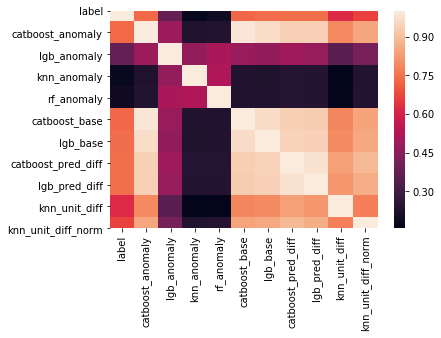

In [198]:
sns.heatmap(model_predictions_train.corr())

### Catboost

In [172]:
catboost_params = {
    'loss_function':'Logloss',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'F1'
}

In [173]:
submission_pool = Pool(data=model_predictions_test[features], cat_features=cat_features)

In [174]:
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
train_class = np.zeros(train_df.shape[0])
test_class = np.zeros(test_df.shape[0])
skf = StratifiedKFold(n_splits=3)
validation_scores = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostClassifier(**catboost_params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    train_preds[test_index] = model.predict_proba(test_pool)[:,1]
    train_class[test_index] = model.predict(test_pool)
    test_preds += model.predict_proba(submission_pool)[:,1]/3
    test_class = model.predict(submission_pool)
    validation_scores.append(f1_score(y_test,model.predict(test_pool),average='micro'))
test_class = np.where(test_class > 2, 1, 0)

Learning rate set to 0.057693
0:	learn: 0.9745223	test: 0.9771583	best: 0.9771583 (0)	total: 15.1ms	remaining: 15.1s
10:	learn: 0.9757573	test: 0.9777992	best: 0.9778979 (9)	total: 102ms	remaining: 9.21s
20:	learn: 0.9761836	test: 0.9777135	best: 0.9782022 (14)	total: 177ms	remaining: 8.26s
30:	learn: 0.9765141	test: 0.9778078	best: 0.9782022 (14)	total: 257ms	remaining: 8.04s
40:	learn: 0.9767420	test: 0.9775075	best: 0.9782022 (14)	total: 329ms	remaining: 7.7s
50:	learn: 0.9774573	test: 0.9774857	best: 0.9782022 (14)	total: 395ms	remaining: 7.36s
60:	learn: 0.9776923	test: 0.9774727	best: 0.9782022 (14)	total: 466ms	remaining: 7.17s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9782021605
bestIteration = 14

Shrink model to first 15 iterations.
Learning rate set to 0.057693
0:	learn: 0.9753756	test: 0.9767665	best: 0.9767665 (0)	total: 4.95ms	remaining: 4.94s
10:	learn: 0.9759915	test: 0.9777223	best: 0.9779271 (5)	total: 78.9ms	remaining: 7.09s
20:	learn: 0.975

In [175]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9561497462743622, 0.005134601491610158, 0.948894783377542)

### Extratrees

In [193]:
et_params = {
    'n_estimators':10,
    'max_depth':3,
    'random_state':0    
}

In [194]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:].values, train.iloc[test_index,:].values
    y_train, y_test = y[train_index], y[test_index]
    
    model = ExtraTreesClassifier(**et_params)
    model.fit(X_train, y_train)
    
    test_preds += model.predict(test.values) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,model.predict(X_test),average='micro'))

In [195]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9563266017772675, 0.004675235890736741, 0.9497789566755085)